# Multi-agent supervisor

The [previous example](../multi-agent-collaboration) routed messages automatically based on the output of the initial researcher agent.

We can also choose to use an [LLM to orchestrate](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) the different agents.

Below, we will create an agent group, with an agent supervisor to help delegate tasks.

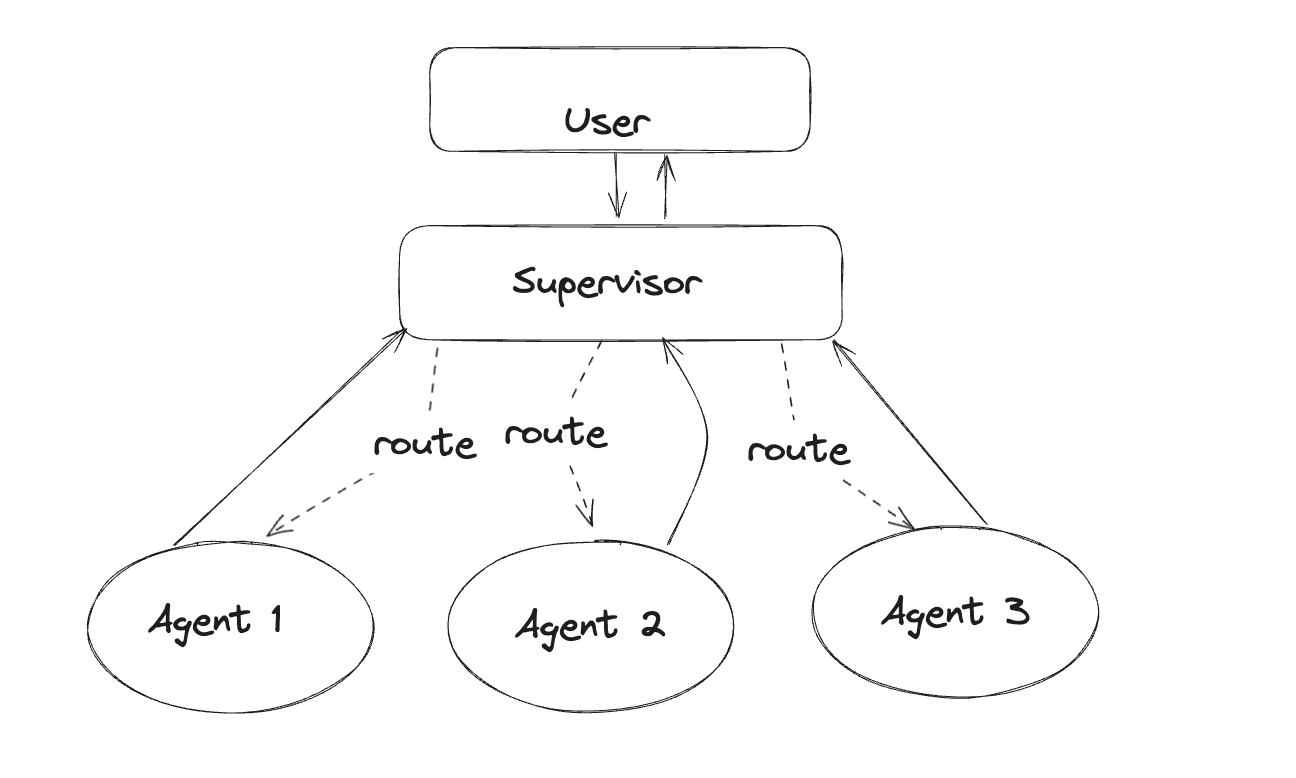

To simplify the code in each agent node, we will use LangGraph's prebuilt [create_react_agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent). This and other "advanced agent" notebooks are designed to show how you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

## Setup

First, let's install required packages and set our API keys

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Create tools

For this example, you will make an agent to do web research with a search engine, and one agent to create plots. Define the tools they'll use below:

In [1]:
from typing import Annotated

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool

tool_search = DuckDuckGoSearchRun()

# This executes code locally, which can be unsafe
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    # We removed the instruction "respond with FINAL ANSWER" from here
    # to stop the model from saying ONLY that.
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

## Helper Utilities

Define a helper function that we will use to create the nodes in the graph - it takes care of converting the agent response to a human message. This is important because that is how we will add it the global state of the graph

In [2]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

### Create Agent Supervisor

It will use function calling to choose the next worker node OR finish processing.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel
from typing import Literal
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members


class routeResponse(BaseModel):
    next: Literal[*options]


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

# Initialize the LLM
#llm = ChatOpenAI(
#        model_name="gpt-4o-mini", temperature=0
#)

llm = ChatGroq(
    model="llama-3.3-70b-versatile"
)

def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

## Construct Graph

We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

In [ ]:
import functools
import operator
from typing import Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langchain.agents import create_agent


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


# 1. Define a strict system prompt for the Coder
code_system_prompt = (
    "You are a Python coding assistant. "
    "1. You MUST use the 'python_repl' tool to execute code. "
    "2. IMPORTANT: When you are done, you MUST include the 'Stdout' content from the tool in your response. "
    "3. Do not just say 'FINAL ANSWER' without showing the code output first. "
    "4. Format your response as: 'Here is the output: [Output] \n FINAL ANSWER'"
)

# 2. Re-create the agents with specific system prompts
# (Assuming 'research_agent' setup is fine, but Coder needs help)
research_agent = create_agent(
    llm, 
    tools=[tool_search], 
    system_prompt="You are a researcher. Search for information as requested."
)

code_agent = create_agent(
    llm, 
    tools=[python_repl], 
    system_prompt=code_system_prompt
)

# 3. Re-wrap them in nodes
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

# 4. Re-build the graph
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)

Now connect all the edges in the graph.

In [5]:
for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

workflow.add_edge(START, "supervisor")

graph = workflow.compile()

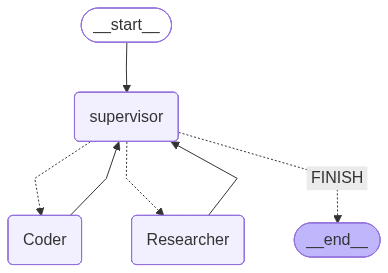

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke the team

With the graph created, we can now invoke it and see how it performs!

In [6]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content='Here is the output: Hello World \n FINAL ANSWER', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [8]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief research report on pikas.")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='Pikas are small mammalian species that reside in mountainous regions. Research has shown that they are sensitive to climate change, which has led to a decline in their population due to factors such as reduced snow cover, increased vegetation, and human activity. Studies have reported upslope range retractions and population declines in various regions, including the Northern Rockies and North Cascades National Park. The decline in pika populations is attributed to various factors, including disease, increased human activity, and predation. Further research is necessary to understand the impact of climate change on pika populations and to develop effective conservation strategies.', additional_kwargs={}, response_metadata={}, name='Researcher')]}}
----
{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='Here is the output: \nPikas are small mammalian species t